In [31]:
%matplotlib widget 

In [1]:
import numpy as np
from numpy import loadtxt
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import pyvisa as visa
from matplotlib import animation
from time import sleep
from matplotlib.animation import FuncAnimation
#Importing the functions from the module and the pulses dictionaries
from Sweeping import *
from Dictionaries import *
from PulseFiles import *
from Instrument import *
import pyqtgraph as pg 
import nidaqmx
import pickle

In [2]:
AWG_Settings7 = {
    'Visa Resource Name': 'TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR',
    'Voltage Amplitude':700,
    'Clock Sample Frecuency':6000000000,
    'Output_Channel': 1,
    'Mode': 'STS',
    'Trigger In Threshold' : 1,
    'Output Rout': 'DAC', #DAC output rout only has the BNC outputs: Direct Out and (Averaged) Direct Out
    'Data Directory': r'D:\Alejandro\Pulses\diode measurements\Pulse Scheme CSV\AutoCorrelation, ms regime, 0,1 probe duration'
}

In [3]:
M8190A = VisaR(AWG_Settings7,60000)

In [14]:
M8190A.query('SYST:ERR?')

'0,"No error"'

In [4]:
Initialization(M8190A,AWG_Settings7)

Instruments Sampling Frecuency set to 6.00000000000000E+09Hz
Instruments Direct Out DAC Output route Voltage set to 7.00000000000000E-01Volts
AWG_Settings_Dict set to TRIGGERED Mode
Trigger In threshold value set to 1.00000000000000E+00V


In [28]:
M8190A.write('SEQ:DEL:ALL')

12

In [5]:
Pump = {
    'Name':'Pump',
    'Amplitude':40,
    'Start time':2,
    'End time':2e-10,
    'Start Duration':1,
    'End Duration':6,
    'Sweep time':0,
    'Sweep Duration':0
}

In [14]:
ProbeAutoA = {
    'Name':'ProbeAutoA',
    'Amplitude':25,
    'Start time':0,
    'End time':4,
    'Start Duration':0.1,
    'End Duration':6,
    'Sweep time':1,
    'Sweep Duration':0
}

In [7]:
ProbeAutoB = {
    'Name':'ProbeAutoB',
    'Amplitude':0,
    'Start time':0,
    'End time':12,
    'Start Duration':1,
    'End Duration':6,
    'Sweep time':0,
    'Sweep Duration':0
}

In [8]:
PulseScheme_AutocorrelationA =  {
    'Name' : 'PulseScheme_AutocorrelationA',
    'Pulse Scheme': [Pump,ProbeAutoA],
    'Number of repetitions': 1,
    'Data Directory': r'D:\Alejandro\Pulses\diode measurements\Pulse Scheme CSV\AutoCorrelation, ms regime, 0,1 probe duration'
}

In [9]:
PulseScheme_AutocorrelationB = {
    'Name' : 'PulseScheme_AutocorrelationB',
    'Pulse Scheme': [ProbeAutoB,ProbeAutoB],
    'Number of repetitions': 1,
    'Data Directory': r'D:\Alejandro\Pulses\diode measurements\Pulse Scheme CSV\AutoCorrelation, ms regime, 0,1 probe duration'
}

Sr = 6Ghz for 5 ms

In [15]:
AutoCorSchemeA = [Pump, ProbeAutoA]
AutoCorSchemeB = [ProbeAutoB, ProbeAutoB]

In [11]:
sam = int(6e9*5e-3)

#sam /480

#M8190A.write('FREQ:RAST 6000000000')

In [10]:
sam

30000000

In [12]:
pul2 = Sweep(AutoCorSchemeB,10,0,5,sam)

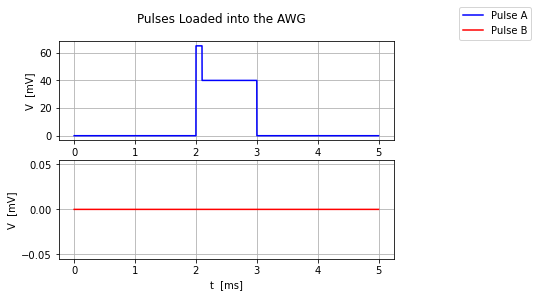

In [16]:
step = 15

pul1 = Sweep(AutoCorSchemeA,30,step,5,sam)


fig,ax= plt.subplots(2)


ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Pulses Loaded into the AWG')


ax[0].plot(pul1[1],pul1[0],label= 'Pulse A',color='blue')
ax[1].plot(pul2[1],pul2[0],label= 'Pulse B',color='red')
ax[0].set_ylabel('V  [mV]')
ax[0].set_xlabel('t  [ms]')
ax[1].set_ylabel('V  [mV]')
ax[1].set_xlabel('t  [ms]')

#ax.set_title('Pulses Loaded into the AWG')

fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#fig.savefig('Pulse_scheme_15ms_7500000',optimize=True,bbox_inches='tight')

In [27]:
test_run = Triggered_Sequence_Setup(AutoCorSchemeA,AutoCorSchemeB,5,0,5,sam,M8190A,AWG_Settings7,1)#beggining

Current Segment Catalogue is 1,30000000  [(segment id, Segment size)]
Current Segment Catalogue is 1,30000000,2,30000000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,29999999,2,1,0,1,0,29999999" and the advancement method is COND


Triggering Pulse Stoped


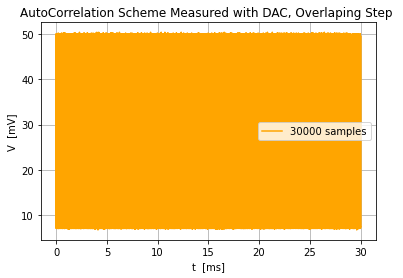

In [11]:
dataM, timeM = DAQ_Measuring(DAQ_Settings1,1000,30,M8190A)

fig,ax= plt.subplots()
ax.grid(True)

#plt.plot(timeMs,dataMs[1]*1000,label= 'Marker Channel {chan}'.format(chan=DAQ_Settings1['Analog Channel Input Marker']),color='purple')
plt.plot(timeM,dataM*1000,label= '{b} samples'.format(b=len(dataM)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('AutoCorrelation Scheme Measured with DAC, Overlaping Step ') #Voltage Offset = 3mV, Marker Ampl = 50mV 
ax.legend(loc=0)
#plt.legend(bbox_to_anchor=(2.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('AutoCorrelation Scheme Meaasured with DAC, Overlaping Step.pdf',bbox_inches='tight')

In [26]:
M8190A.write('SEQ:DEL:ALL')

12

In [17]:
def Sweeping_Single_List_File(PulseList,P,t,N,start,stop,AWG_Settings_Dict,cycle):

    """ Given a pulse scheme list, this functions iterates the pulse scheme from start to stop.

        This function firts creates the corresponding pulse sequence csv data given the PulseList using the Sweep_iteration_csv function
        
    """
    
    if cycle == 'A':
        #Markers for cycle A
        Loc1,DF1,timm = Sweep_Iteration_CSV_List(PulseList,P,t,N,start,stop,AWG_Settings_Dict,1)

    if cycle == 'B':
        #Markers for cycle B
        Loc1,DF1,timm = Sweep_Iteration_CSV_List(PulseList,P,t,N,start,stop,AWG_Settings_Dict,0)

    return Loc1, DF1, timm


In [18]:
sweeping_run_a = Sweeping_Single_List_File(AutoCorSchemeA,30,5,sam,0,30,AWG_Settings7,'A')[0]
sweeping_runb = pickle.load(open("sweepingB_30steps_5ms.p", "rb"))

<ipython-input-18-c64509652ddb>:2: ResourceWarning: unclosed file <_io.BufferedReader name='sweepingB_30steps_5ms.p'>
  sweeping_runb = pickle.load(open("sweepingB_30steps_5ms.p", "rb"))


In [23]:
#exporting pickle 

pickle.dump(sweeping_run_a, open("sweepingA_30steps_5ms_pointone.p", "wb"))  # save it into a file named sweepingA.p
#pickle.dump(sweeping_run[1], open("sweepingB_30steps_5ms_pointfivestep.p", "wb"))  # save it into a file named sweepingB.p


<ipython-input-23-0165d0d580ad>:3: ResourceWarning: unclosed file <_io.BufferedWriter name='sweepingA_30steps_5ms_pointone.p'>
  pickle.dump(sweeping_run_a, open("sweepingA_30steps_5ms_pointone.p", "wb"))  # save it into a file named sweepingA.p


In [12]:
#importing pickle

#sweeping_runa = pickle.load(open("sweepingA_30steps_5ms.p", "rb"))
#sweeping_runb = pickle.load(open("sweepingB_30steps_5ms.p", "rb"))

<ipython-input-12-5537eada0aa2>:3: ResourceWarning: unclosed file <_io.BufferedReader name='sweepingA_30steps_5ms.p'>
  sweeping_runa = pickle.load(open("sweepingA_30steps_5ms.p", "rb"))
<ipython-input-12-5537eada0aa2>:4: ResourceWarning: unclosed file <_io.BufferedReader name='sweepingB_30steps_5ms.p'>
  sweeping_runb = pickle.load(open("sweepingB_30steps_5ms.p", "rb"))


In [ ]:
ListB = [*sweeping_runb]

In [31]:
sweeping_runb

{'Pulse File Location, at step 0': 'D:\\Alejandro\\Pulses\\Dict\\S5\\SegmentB_30000000_0.csv',
 'Pulse File Location, at step 1': 'D:\\Alejandro\\Pulses\\Dict\\S5\\SegmentB_30000000_1.csv',
 'Pulse File Location, at step 2': 'D:\\Alejandro\\Pulses\\Dict\\S5\\SegmentB_30000000_2.csv',
 'Pulse File Location, at step 3': 'D:\\Alejandro\\Pulses\\Dict\\S5\\SegmentB_30000000_3.csv',
 'Pulse File Location, at step 4': 'D:\\Alejandro\\Pulses\\Dict\\S5\\SegmentB_30000000_4.csv',
 'Pulse File Location, at step 5': 'D:\\Alejandro\\Pulses\\Dict\\S5\\SegmentB_30000000_5.csv',
 'Pulse File Location, at step 6': 'D:\\Alejandro\\Pulses\\Dict\\S5\\SegmentB_30000000_6.csv',
 'Pulse File Location, at step 7': 'D:\\Alejandro\\Pulses\\Dict\\S5\\SegmentB_30000000_7.csv',
 'Pulse File Location, at step 8': 'D:\\Alejandro\\Pulses\\Dict\\S5\\SegmentB_30000000_8.csv',
 'Pulse File Location, at step 9': 'D:\\Alejandro\\Pulses\\Dict\\S5\\SegmentB_30000000_9.csv',
 'Pulse File Location, at step 10': 'D:\\Alejandro

In [32]:
haber = Sequence_Loader_File_DAQ_np(M8190A,DAQ_Settings1,1000,30,sweeping_run_a,sweeping_runb)

Sequence loaded with the following segment data "1,1,0,1,0,29999999,2,1,0,1,0,29999999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 0
Sequence loaded with the following segment data "1,1,0,1,0,29999999,2,1,0,1,0,29999999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 1
Sequence loaded with the following segment data "1,1,0,1,0,29999999,2,1,0,1,0,29999999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 2
Sequence loaded with the following segment data "1,1,0,1,0,29999999,2,1,0,1,0,29999999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 3
Sequence loaded with the following segment data "1,1,0,1,0,29999999,2,1,0,1,0,29999999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 4
Sequence loaded with the following segment data "1,1,0,1,0,29999999,2,1,0,1,0,29999999" and the advancement method is COND
Triggering Pulse 

In [21]:
for i in range(0,len(haber)):
    print(i)

260 ,16

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [26]:
haber[0][0][5000]

2.666900309197106

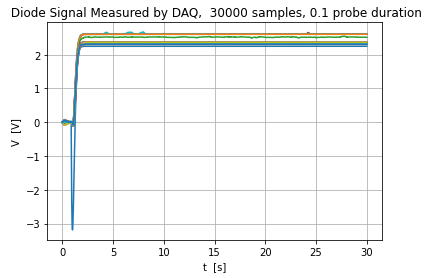

In [33]:
fig,ax= plt.subplots()
ax.grid(True)
for i in range(0,len(haber)):
    plt.plot(haber[i][1],haber[i][0],label= 'Step {st}'.format(st = i ))

ax.set_ylabel(r'V  [V]')
ax.set_xlabel('t  [s]')
ax.set_title(' Diode Signal Measured by DAQ,  {b} samples, 0.1 probe duration'.format(b = len(haber[0][1]) ))
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#ax.legend(loc=0)
plt.show()
fig.savefig('Diode Signal time cstant = 300ms sensitivity 5mV,30seconds, 5ms scheme, probe duration 0.1s,30 steps, no legend .jpeg',bbox_inches='tight')

In [34]:
location = r'D:\Alejandro\Pulses\diode measurements\Pulse duration 1, ms regime, 30 steps 0,1 probe'

In [35]:
for i in range(0,len(haber)):
    np.savetxt(r'{loc}\diode_signal_step{stp}_35s_5ms.csv'.format(loc = location ,stp = i), haber[i][0], delimiter=',') 

chopped_measurement_data = np.zeros((len(haber)),  dtype=object)
for i in range(0,len(haber)):
    chopped_measurement_data[i] = haber[i][0][3500:] 

avr = np.array([np.average(i) for i in chopped_measurement_data])
np.savetxt(r'{loc}\averaged signal_30steps.csv'.format(loc =location),avr,delimiter=',')

In [38]:
np.savetxt(r'averaged signal_30steps_point1.csv'.format(loc =location),avr,delimiter=',')

In [3]:
time_delay = np.linspace(-2,2,31)

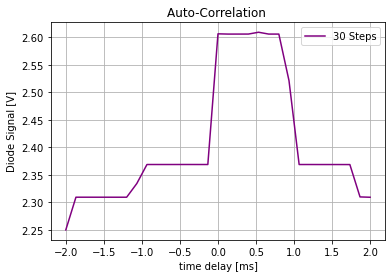

In [40]:
#change this to V regime
fig,axes = plt.subplots()

axes.grid(True)

plt.plot(time_delay,avr,label='30 Steps',color='purple')
#plt.plot(tm,pul,label = '{a} samples'.format(a = len(pul)))

axes.set_xlabel('time delay [ms]')
axes.set_ylabel(r'Diode Signal [V]')
axes.set_title('Auto-Correlation ')

axes.legend(loc = 0)
plt.show()

fig.savefig('Autocorrelation function 30 steps ms regime 0,1 probe.jpeg',bbox_inches='tight')

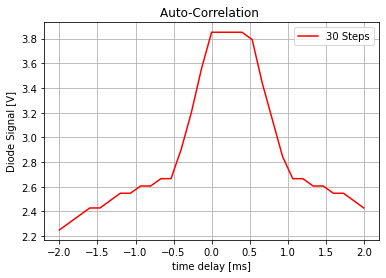

In [27]:
fig,axes = plt.subplots()

axes.grid(True)

axes.plot(time_delay,avr,label='30 Steps',color='red')
#plt.plot(tm,pul,label = '{a} samples'.format(a = len(pul)))

axes.set_xlabel('time delay [ms]')
axes.set_ylabel(r'Diode Signal [V]')
axes.set_title('Auto-Correlation ')

axes.legend(loc = 0)
plt.show()

fig.savefig('Autocorrelation function 35 steps ms regime pointfive.jpeg',bbox_inches='tight')

# Load numpy array from csv file


In [2]:
# load array
avrg = loadtxt('averaged signal_30steps_point1.csv',delimiter = ',')
avrg_2 = loadtxt('averaged signal_30steps_35seconds.csv', delimiter=',')
avrg_pointfive = loadtxt('averaged signal_30steps_35seconds_pointfive.csv', delimiter=',')
# print the array
print(avrg_2)

[2.66621785 2.72604334 2.80564115 2.87766861 2.94294133 2.99468922
 3.0224815  3.08143928 3.25949225 3.61449185 3.96971482 4.26694751
 4.6225823  4.91890416 5.21575707 5.45626223 5.21576647 4.9186144
 4.56335832 4.26685142 3.91087182 3.55502107 3.25838228 3.02227942
 2.96285098 2.90340398 2.84407454 2.78493408 2.66615176 2.60695078
 2.52269574]


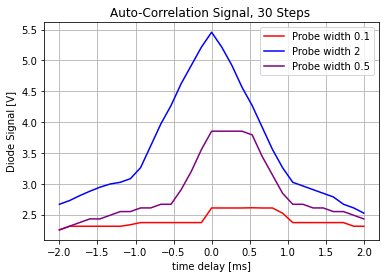

In [10]:
fig,axes = plt.subplots()

axes.grid(True)

plt.plot(time_delay,avrg,label='Probe width 0.1',color='red')
plt.plot(time_delay,avrg_2,label='Probe width 2',color='blue')
plt.plot(time_delay,avrg_pointfive,label = 'Probe width 0.5', color = 'purple')

axes.set_xlabel('time delay [ms]')
axes.set_ylabel(r'Diode Signal [V]')
axes.set_title('Auto-Correlation Signal, 30 Steps ')

axes.legend(loc = 0)
plt.show()

#fig.savefig('Autocorrelation point 1.jpeg',bbox_inches='tight')

In [22]:
 np.where(haber[0][1] > 3 )

(array([ 3000,  3001,  3002, ..., 34997, 34998, 34999], dtype=int64),)

In [46]:
%matplotlib inline

In [12]:
import glob
print(glob.glob('D:\Alejandro\Pulses\diode measurements\Pulse Scheme CSV\AutoCorrelation, ms regime, 0,1 probe duration\*csv'))
#print(glob.glob("/home/adam/*"))

['D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_0.csv', 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_1.csv', 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_10.csv', 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_11.csv', 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_12.csv', 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_13.csv', 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_14.csv', 'D:\\Alejandro\\Pulses\\diode measurements

In [13]:
a = glob.glob('D:\Alejandro\Pulses\diode measurements\Pulse Scheme CSV\AutoCorrelation, ms regime, 0,1 probe duration\*csv')

In [18]:
a

['D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_0.csv',
 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_1.csv',
 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_10.csv',
 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_11.csv',
 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_12.csv',
 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_13.csv',
 'D:\\Alejandro\\Pulses\\diode measurements\\Pulse Scheme CSV\\AutoCorrelation, ms regime, 0,1 probe duration\\SegmentA_30000000_14.csv',
 'D:\\Alejandro\\Pulses\\diode measu

# Tiling

In [42]:
Pump = {
    'Name':'Pump',
    'Amplitude':40,
    'Start time':2e-10,
    'End time':2e-10,
    'Start Duration':2,
    'End Duration':6,
    'Sweep time':0,
    'Sweep Duration':0
}

In [43]:
ProbeAutoA = {
    'Name':'ProbeAutoA',
    'Amplitude':25,
    'Start time':0,
    'End time':4,
    'Start Duration':1,
    'End Duration':6,
    'Sweep time':1,
    'Sweep Duration':0
}

In [44]:
ProbeAutoB = {
    'Name':'ProbeAutoB',
    'Amplitude':0,
    'Start time':0,
    'End time':12,
    'Start Duration':1,
    'End Duration':6,
    'Sweep time':0,
    'Sweep Duration':0
}

In [45]:
ProbeAutoC = {
    'Name':'ProbeAutoB',
    'Amplitude':35,
    'Start time':3,
    'End time':12,
    'Start Duration':3,
    'End Duration':6,
    'Sweep time':0,
    'Sweep Duration':0
}

In [46]:
AutoCorSchemeA = [Pump, ProbeAutoA]
AutoCorSchemeB = [ProbeAutoB, ProbeAutoB]
AutoCorSchemeC = [Pump,ProbeAutoC]
#step = 0

In [47]:
ProbeAutoC = {
    'Name':'ProbeAutoB',
    'Number of Repetitions': 1,
    'Amplitude':35,
    'Start time':6,
    'End time':12,
    'Start Duration':3,
    'End Duration':6,
    'Sweep time':0,
    'Sweep Duration':0
}

In [48]:
PulseSchemetest =  {
    'Name' : 'PulseSchemetest',
    'Pulse Scheme': [Pump,ProbeAutoC],
    'Number of repetitions': 4,
}

In [40]:
def Sweepteil(PulList,P,p,t,N):
    
    """Function that perfoms or not a Sweep, depending on the Sweep dictionary keys, for the Pulse Scheme PulList.
    
    This function is a generalization of the sweep0(Pulse,P,p,t).
    It calls it and maps it over every Pulse in the list of pulses PulList.
    If two pulses overlap, their amplitude is added up.
    P gives the number of sample points for the overal pulse scheme, not to be confused with dt, the sweeping time step given by P
    The pulse sequence is generated in the order that the pulses have within the PulseList.
    """
    
    #time interval
    time = np.linspace(0,t,N)
    
    #Each pulse will be an array, and an entry of a bigger array (we have an array of arrays)
    pularray = np.array([sweep0(Pulse,P,p,t,N) for Pulse in PulList['Pulse Scheme']])
        
    #the final pulse scheme will be the overlap of each individual pulse, given by the sum of their arrays    
    pulscheme0 = np.sum(pularray,0)

    #we divide the pulse scheme in order to play it several times
    teil = int(pulscheme0.size/PulList['Number of repetitions'])
    pulscheme = np.tile(pulscheme0[:teil],PulList['Number of repetitions'])
    
        
    return pulscheme, time

In [40]:
def Sweept(PulList,P,p,t,N,rep):
    
    """Function that perfoms or not a Sweep, depending on the Sweep dictionary keys, for the Pulse Scheme PulList.
    
    This function is a generalization of the sweep0(Pulse,P,p,t).
    It calls it and maps it over every Pulse in the list of pulses PulList.
    If two pulses overlap, their amplitude is added up.
    P gives the number of sample points for the overal pulse scheme, not to be confused with dt, the sweeping time step given by P
    The pulse sequence is generated in the order that the pulses have within the PulseList.
    """
    
    #time interval
    time = np.linspace(0,t,N)
    
    #Each pulse will be an array, and an entry of a bigger array (we have an array of arrays)
    pularray = np.array([sweep0(Pulse,P,p,t,N) for Pulse in PulList['Pulse Scheme']])
        
    #the final pulse scheme will be the overlap of each individual pulse, given by the sum of their arrays    
    pulscheme0 = np.sum(pularray,0)

    #we divide the pulse scheme in order to play it several times
    teil = int(pulscheme0.size/rep)
    pulscheme = np.tile(pulscheme0[:teil],rep)
    
        
    return pulscheme, time

In [49]:
pul = Sweept(PulseSchemetest,10,0,100,7500000,10)

In [52]:
n = 10
pul = Sweept(PulseSchemetest,10,0,100,7500000,n)
#teil = int(pul[0].size/n)
#huh = np.tile(pul[0][:teil],n)

fig,axes = plt.subplots()
axes.grid(True)

plt.plot(pul[1],pul[0],label = 'Step 0' )
#plt.plot(tim2,pul1,label = 'part2' )

axes.set_xlabel('t [ms]')
axes.set_ylabel('v[mV]')
axes.set_title('Auto-Correlation Cycle A repeated {a} times'.format( a = n ))

#axes.legend(loc = 0)
plt.show()

#fig.savefig('{a} pulses per segment.png'.format( a = n))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

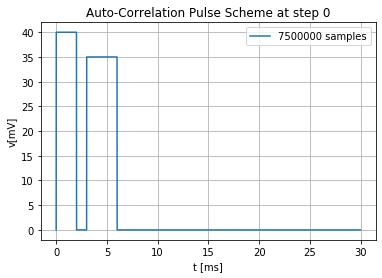

In [89]:
fig,axes = plt.subplots()

axes.grid(True)

plt.plot(pul[1],pul[0],label = '{a} samples'.format(a = len(pul[0])))
#plt.plot(tm,pul,label = '{a} samples'.format(a = len(pul)))

axes.set_xlabel('t [ms]')
axes.set_ylabel('v[mV]')
axes.set_title('Auto-Correlation Pulse Scheme at step 0')

axes.legend(loc = 0)
plt.show()